In [47]:
# for QR codes use inline
%matplotlib inline
# qr_setting = 'url'
#
# for lecture use notebook
%matplotlib notebook
qr_setting = None
#
# %config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import laUtilities as ut
import slideUtilities as sl
import demoUtilities as dm
import pandas as pd
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
reload(sl)
reload(ut);

## Animate quadratic forms

In [2]:
import matplotlib as mp
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

In [3]:
# two methods for animation - see:
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
# 1 - directly inline via %matplotlib notebook - advantage: real-time, disadvantage: no manual control
# 2 - encode as video, embedded into notebook (base64) and display via notebook player or JS widget
#     downside - not real time, need to generate complete video before it can be displayed
# 2a - HTML(anim.to_html5_video())  [notebook player, bare bones] [uses html5 <video> tag]
# 2b - HTML(anim.to_jshtml())  [JS widget, extra controls]
# these latter can be made default representation via next line, which can also be 'html5'
mp.rcParams['animation.html'] = 'jshtml'
# 3 - save as an animated GIF and display using 
# rot_animation.save('rotation.gif', dpi=80, writer='imagemagick')
# ![RotatingImage](rotation.gif "Quadratic Form")
# see also https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531

In [4]:
def qf(lam1, lam2, e1, e2):
    return np.array([e1, e2]).T @ np.diag([lam1, lam2]) @ np.array([e1, e2])

In [5]:
def eval_qf(qf, x, y):
    xvec = np.array([x, y])
    return xvec.T @ qf @ xvec

In [6]:
xmin = -3
xmax = 3
ymin = -3
ymax = 3
zmin = -3
zmax = 3

# two remaining issues:
# 1. triangulation artifacts
#    problem is that triangulation creates triangles that all get mapped
#    to the zmin in regions where surface is below zmin
# possible solution: explicitly designate the boundary points, and do not 
#   create any triangles that include 3 boundary points
# 2. limit of xrange when hyperbolic surface intesects zmax
#    - ie, need to allow for two separate yranges beyond that point, 
#      but current logic does not allow
#    need to think about where surface lies within z bounds
# to see both issues, eg, use:
# qf_test = 0.25 * qf(5, -5, [1, 0], [0, 1])
# consider also the BBox clipping 

qf_test = 0.25 * qf(5, -5, [1, 0], [0, 1])

In [7]:
# find the portion that is contained within two ranges r1 and r2
def range_intersect(r1, r2):
    return [np.nanmax([r1[0], r2[0]]), np.nanmin([r1[1], r2[1]])]

def range_union(r1, r2):
    return [np.nanmin([r1[0], r2[0]]), np.nanmax([r1[1], r2[1]])]

In [8]:
# first find the limits of x and y for grid creation
# the limits will occur along the eigenvectors of the QF
e, v = np.linalg.eig(qf_test)

# x_limit is the +/- value of x that lies on this eigenvector
# and for which the qf = some_z
def axes_limit(qf, z, evec):
    # for any eigenvector evec, y = alpha x, so alpha = y/x = evec[1]/evec[0]
    if evec[0] == 0:
        alpha = evec[0]/evec[1]
        # switch places of x and y since y can't be given in terms of x
        y = np.sqrt(z / (qf[1, 1] + alpha * (qf[0, 1] + qf[1, 0]) + alpha**2 * qf[0, 0]))
        return [[-alpha*y, -y], [alpha*y, y]]
    else:
        alpha = evec[1]/evec[0]
        # substituting y = alpha x into the quadratric form yields
        x = np.sqrt(z / (qf[0, 0] + alpha * (qf[0, 1] + qf[1, 0]) + alpha**2 * qf[1, 1]))
        return [[-x, -alpha*x], [x, alpha*x]]

r1 = axes_limit(qf_test, zmax, v[:,0])
r2 = axes_limit(qf_test, zmax, v[:,1])
xrange_max = range_union([r1[0][0], r1[1][0]], [r2[0][0], r2[1][0]])
print(xrange_max)
r1 = axes_limit(qf_test, zmin, v[:,0])
r2 = axes_limit(qf_test, zmin, v[:,1])
print(r1)
print(r2)
xrange_min = range_union([r1[0][0], r1[1][0]], [r2[0][0], r2[1][0]])
print(xrange_min)
final_xrange = range_union(xrange_max, xrange_min)
final_xrange = range_intersect([xmin, xmax], final_xrange)
print(final_xrange)

[-1.5491933384829668, 1.5491933384829668]
[[nan, nan], [nan, nan]]
[[-0.0, -1.5491933384829668], [0.0, 1.5491933384829668]]
[-0.0, 0.0]
[-1.5491933384829668, 1.5491933384829668]


/Users/markcrovella/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/markcrovella/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


In [20]:
def fun(x, y):
    return eval_qf(qf_test, x, y)

x_vals = np.linspace(final_xrange[0], final_xrange[1], 50)
# for each x, compute the ymin and ymax vals where the surface exceeds or is below zmax, zmin
# find y such that [x, y]T Q [x y] = zmin, zmax

def quad_zeros(a, b, c):
    disc = b**2 - 4*a*c
    if disc < 0:
        return [np.nan, np.nan]
    else:
        return sorted([(-b - np.sqrt(disc))/(2*a), (-b + np.sqrt(disc))/(2*a)])

def solve_y(qf_in, x, z):
    A = qf_in[1, 1]
    B = (qf_in[1, 0] + qf_in[0, 1]) * x
    C = (qf_in[0, 0] * x**2) - z
    return quad_zeros(A, B, C)

# the reason for going beyond the ranges given by the limits of the cube is as follows
# the triagulation assumes a surface that connects all points.  when the grid limit is bounded by the
# enclosing cube, the triangulation connects points that lie on the boundary of the cube, but
# are not actually connected on the surface.   So we introduce a row of points just outside the cube, 
# and given those points the zval of nan -- meaning that they will not be plotted as part of the 
# surface
#
# THEN - took that hack out b/c it was introducing jagged edges in some cases.
X = []
Y = []
Z = []
boundary_points = []
boundary_indices = []
eps = 0.00001
for x in x_vals:
    y_min_intcpt, y_max_intcpt = solve_y(qf_test, x, zmax)
    if np.isnan(y_min_intcpt):
        # surface does not cross the zmax plane
        y_min_intcpt, y_max_intcpt = solve_y(qf_test, x, zmin)
        if np.isnan(y_min_intcpt):
            # surface does not cross the zmin plane
            ztest = eval_qf(qf_test, x, ymin)
            if ((ztest <= zmax) & (ztest >= zmin)):
                # surface lies entirely within z boundaries (this should not happen)
                # X += 52*[x]
                X += 50*[x]
                valids = list(np.linspace(ymin, ymax, 50))
                boundary_points += [[x, ymin], [x, ymax]]
                boundary_indices += [len(X) - 50, len(X)-1]
                # Y += [ymin-eps] + valids + [ymax+eps]
                Y += valids
                # Z += [np.nan] + [fun(x, y) for x, y in zip(50*[x], valids)] + [np.nan]
                Z += [fun(x, y) for x, y in zip(50*[x], valids)]
            else:
                # surface lies entirely outside z boundaries
                pass
        else:
            # surface crosses zmin but not zmax plane
            # X += 52*[x]
            X += 50*[x]
            y_start, y_end = range_intersect([y_min_intcpt, y_max_intcpt], [ymin, ymax])
            valids = list(np.linspace(y_start, y_end, 50))
            boundary_points += [[x, y_start], [x, y_end]]
            boundary_indices += [len(X) - 50, len(X)-1]
            # Y += [y_start-eps] + valids + [y_end+eps]
            Y += valids 
            # Z += [np.nan] + [fun(x, y) for x, y in zip(50*[x], valids)] + [np.nan]
            Z += [fun(x, y) for x, y in zip(50*[x], valids)] 
    else:
        # surface does cross zmax plane
        # need to decide if range in between crossings is in or out of visualization cube
        # WORK ON THIS -- GENERALIZE to zmin plane -- THEN generalize notion of axes_limits computed above
        # note that triangulation may have trouble dealing with region between, where surface is out of box
        # perhaps put one point in between, with a zvalue of nan?
        y_start, y_end = range_intersect([y_min_intcpt, y_max_intcpt], [ymin, ymax])
        y_min_intcpt, y_max_intcpt = solve_y(qf_test, x, zmin)
        if np.isnan(y_min_intcpt):
            # surface does not cross the zmin plane
            # X += 52*[x]
            X += 50*[x]
            valids = list(np.linspace(y_start, y_end, 50))
            boundary_points += [[x, y_start], [x, y_end]]
            boundary_indices += [len(X) - 50, len(X)-1]
            # Y += [y_start-eps] + valids + [y_end+eps]
            Y += valids 
            # Z += [np.nan] + [fun(x, y) for x, y in zip(50*[x], valids)] + [np.nan]
            Z += [fun(x, y) for x, y in zip(50*[x], valids)] 
        else:
            # surface crosses zmin and zmax planes
            # have already taken zmax crossings into account in y_start, y_end
            y_start, y_end = range_intersect([y_min_intcpt, y_max_intcpt], [y_start, y_end])
            # X += 52*[x]
            X += 50*[x]
            valids = list(np.linspace(y_start, y_end, 50))
            boundary_points += [[x, y_start], [x, y_end]]
            boundary_indices += [len(X) - 50, len(X)-1]
            # Y += [y_start-eps] + valids + [y_end+eps]
            Y += valids 
            # Z += [np.nan] + [fun(x, y) for x, y in zip(50*[x], valids)] + [np.nan]
            Z += [fun(x, y) for x, y in zip(50*[x], valids)] 
    

<IPython.core.display.Javascript object>


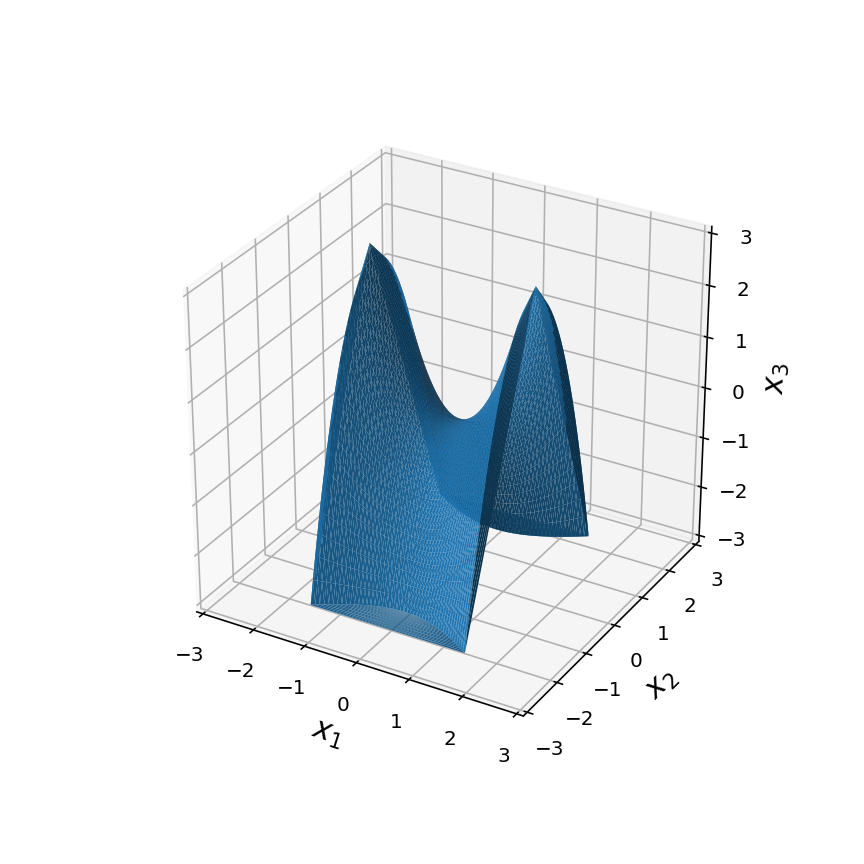

In [53]:
%matplotlib notebook 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.axes.set_xlim([xmin, xmax])
ax.axes.set_ylim([ymin, ymax])
ax.axes.set_zlim([zmin, zmax])
ax.axes.set_xlabel('$x_1$',size=15)
ax.axes.set_ylabel('$x_2$',size=15)
ax.axes.set_zlabel('$x_3$',size=15)

triang = mp.tri.Triangulation(X, Y)

zs = np.array([fun(x, y) for x, y in zip(X, Y)])

# zs[(zs>zmax)|(zs<zmin)] = np.nan
#zs[zs<zmin] = np.nan


def init_func():
    ax.plot_trisurf(triang,
                            Z,
                            # color=color,
                            # alpha=alpha,
                            linewidth=0)
    
init_func()
plt.show()

In [55]:
triang.neighbors

array([[  17,   21,  566],
       [  -1,    2,   98],
       [4516,  101,    1],
       ...,
       [4797, 4150, 4794],
       [4791, 4797, 4361],
       [4358, 4795, 4796]], dtype=int32)

In [56]:
triang.edges

array([[  49,    0],
       [  50,    0],
       [  51,    0],
       ...,
       [2499, 2448],
       [2499, 2449],
       [2499, 2450]], dtype=int32)

In [57]:
boundary_indices

[0,
 49,
 50,
 99,
 100,
 149,
 150,
 199,
 200,
 249,
 250,
 299,
 300,
 349,
 350,
 399,
 400,
 449,
 450,
 499,
 500,
 549,
 550,
 599,
 600,
 649,
 650,
 699,
 700,
 749,
 750,
 799,
 800,
 849,
 850,
 899,
 900,
 949,
 950,
 999,
 1000,
 1049,
 1050,
 1099,
 1100,
 1149,
 1150,
 1199,
 1200,
 1249,
 1250,
 1299,
 1300,
 1349,
 1350,
 1399,
 1400,
 1449,
 1450,
 1499,
 1500,
 1549,
 1550,
 1599,
 1600,
 1649,
 1650,
 1699,
 1700,
 1749,
 1750,
 1799,
 1800,
 1849,
 1850,
 1899,
 1900,
 1949,
 1950,
 1999,
 2000,
 2049,
 2050,
 2099,
 2100,
 2149,
 2150,
 2199,
 2200,
 2249,
 2250,
 2299,
 2300,
 2349,
 2350,
 2399,
 2400,
 2449,
 2450,
 2499]

In [62]:
mask = [(t[0] in boundary_indices) for t in triang.neighbors]
np.sum(np.array(mask))

97

In [65]:
boundary_points

[[-1.5491933384829668, -1.884864366154897e-08],
 [-1.5491933384829668, 1.884864366154897e-08],
 [-1.4859609573203967, -2.1466438844579114],
 [-1.4859609573203967, 2.1466438844579114],
 [-1.4227285761578266, -2.1033679186999303],
 [-1.4227285761578266, 2.1033679186999303],
 [-1.3594961949952566, -2.061123456808587],
 [-1.3594961949952566, 2.061123456808587],
 [-1.2962638138326865, -2.019975216445009],
 [-1.2962638138326865, 2.019975216445009],
 [-1.2330314326701164, -1.9799915439093472],
 [-1.2330314326701164, 1.9799915439093472],
 [-1.1697990515075465, -1.9412444000969984],
 [-1.1697990515075465, 1.9412444000969984],
 [-1.1065666703449764, -1.9038092855951636],
 [-1.1065666703449764, 1.9038092855951636],
 [-1.0433342891824062, -1.86776509202409],
 [-1.0433342891824062, 1.86776509202409],
 [-0.9801019080198361, -1.8331938659356581],
 [-0.9801019080198361, 1.8331938659356581],
 [-0.9168695268572661, -1.8001804713082148],
 [-0.9168695268572661, 1.8001804713082148],
 [-0.8536371456946961, 

In [68]:
triang.set_mask(None)
[t for t in triang.neighbors]

[array([ 17,  21, 566], dtype=int32),
 array([-1,  2, 98], dtype=int32),
 array([4516,  101,    1], dtype=int32),
 array([  97, 1902,  107], dtype=int32),
 array([997,  16, 109], dtype=int32),
 array([106, 112, 111], dtype=int32),
 array([  11,   13, 4539], dtype=int32),
 array([444, 121, 124], dtype=int32),
 array([ 455,   47, 1124], dtype=int32),
 array([144,  12,  11], dtype=int32),
 array([ 19, 143,  11], dtype=int32),
 array([ 9,  6, 10], dtype=int32),
 array([  9, 142,  13], dtype=int32),
 array([14,  6, 12], dtype=int32),
 array([4567,   13,  562], dtype=int32),
 array([998, 148,  16], dtype=int32),
 array([  4,  15, 151], dtype=int32),
 array([  0,  18, 576], dtype=int32),
 array([565, 160,  17], dtype=int32),
 array([153,  10,  20], dtype=int32),
 array([  22, 1311,   19], dtype=int32),
 array([  0, 577,  22], dtype=int32),
 array([3035,   20,   21], dtype=int32),
 array([165, 582,  24], dtype=int32),
 array([161,  25,  23], dtype=int32),
 array([ 24, 366, 173], dtype=int32),


In [67]:
triang.neighbors

array([[  -1,   -1,  566],
       [  -1,    2,   98],
       [4516,  101,    1],
       ...,
       [4797, 4150, 4794],
       [4791, 4797, 4361],
       [4358, 4795, 4796]], dtype=int32)

<IPython.core.display.Javascript object>


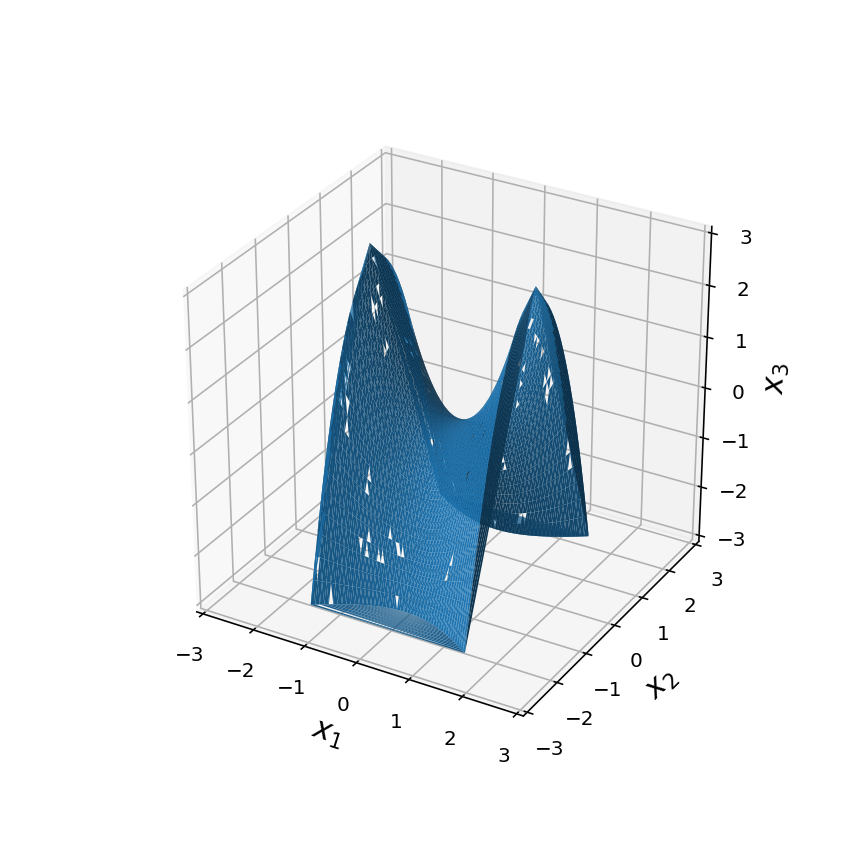

In [64]:
%matplotlib notebook 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.axes.set_xlim([xmin, xmax])
ax.axes.set_ylim([ymin, ymax])
ax.axes.set_zlim([zmin, zmax])
ax.axes.set_xlabel('$x_1$',size=15)
ax.axes.set_ylabel('$x_2$',size=15)
ax.axes.set_zlabel('$x_3$',size=15)

ax.plot_trisurf(triang,
                            Z,
                            # color=color,
                            # alpha=alpha,
                            linewidth=0)
plt.show()

In [71]:
def coord_to_ndx(i, j):
    return i*50 + j

def triang1(i, j):
    return [coord_to_ndx(i, j), coord_to_ndx(i+1, j), coord_to_ndx(i, j+1)]

def triang2(i, j):
    return [coord_to_ndx(i+1, j), coord_to_ndx(i+1, j+1), coord_to_ndx(i, j+1)]

triangles = []
for i in range(49):
    for j in range(49):
        triangles.append(triang1(i,j))
        triangles.append(triang2(i,j))        

<IPython.core.display.Javascript object>


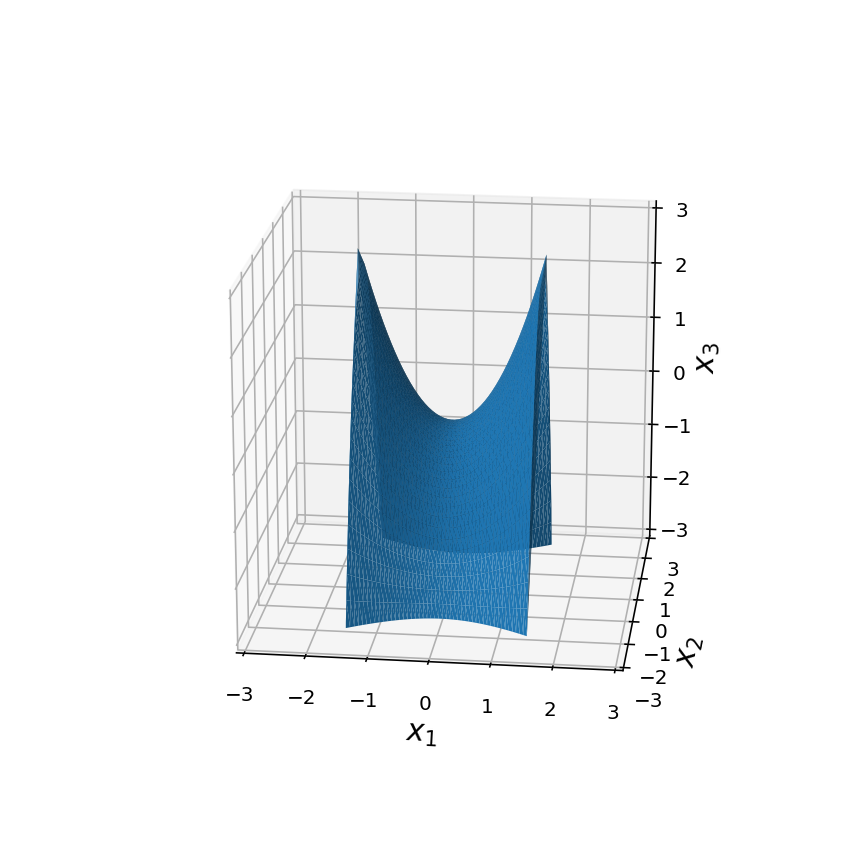

In [73]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.axes.set_xlim([xmin, xmax])
ax.axes.set_ylim([ymin, ymax])
ax.axes.set_zlim([zmin, zmax])
ax.axes.set_xlabel('$x_1$',size=15)
ax.axes.set_ylabel('$x_2$',size=15)
ax.axes.set_zlabel('$x_3$',size=15)

triang = mp.tri.Triangulation(X, Y, triangles=triangles)

zs = np.array([fun(x, y) for x, y in zip(X, Y)])

ax.plot_trisurf(triang,
                            Z,
                            # color=color,
                            # alpha=alpha,
                            linewidth=0)
plt.show()

In [72]:
triangles

[[0, 50, 1],
 [50, 51, 1],
 [1, 51, 2],
 [51, 52, 2],
 [2, 52, 3],
 [52, 53, 3],
 [3, 53, 4],
 [53, 54, 4],
 [4, 54, 5],
 [54, 55, 5],
 [5, 55, 6],
 [55, 56, 6],
 [6, 56, 7],
 [56, 57, 7],
 [7, 57, 8],
 [57, 58, 8],
 [8, 58, 9],
 [58, 59, 9],
 [9, 59, 10],
 [59, 60, 10],
 [10, 60, 11],
 [60, 61, 11],
 [11, 61, 12],
 [61, 62, 12],
 [12, 62, 13],
 [62, 63, 13],
 [13, 63, 14],
 [63, 64, 14],
 [14, 64, 15],
 [64, 65, 15],
 [15, 65, 16],
 [65, 66, 16],
 [16, 66, 17],
 [66, 67, 17],
 [17, 67, 18],
 [67, 68, 18],
 [18, 68, 19],
 [68, 69, 19],
 [19, 69, 20],
 [69, 70, 20],
 [20, 70, 21],
 [70, 71, 21],
 [21, 71, 22],
 [71, 72, 22],
 [22, 72, 23],
 [72, 73, 23],
 [23, 73, 24],
 [73, 74, 24],
 [24, 74, 25],
 [74, 75, 25],
 [25, 75, 26],
 [75, 76, 26],
 [26, 76, 27],
 [76, 77, 27],
 [27, 77, 28],
 [77, 78, 28],
 [28, 78, 29],
 [78, 79, 29],
 [29, 79, 30],
 [79, 80, 30],
 [30, 80, 31],
 [80, 81, 31],
 [31, 81, 32],
 [81, 82, 32],
 [32, 82, 33],
 [82, 83, 33],
 [33, 83, 34],
 [83, 84, 34],
 [34, 84

In [11]:
# putting plt.show() works for %matplotlib notebook
def rotate(angle):
    ax.view_init(azim=angle)
    # plt.show()

rot_animation = animation.FuncAnimation(fig, 
                                        rotate, 
                                        frames=np.arange(0,360,5), 
                                        init_func=init_func,
                                        interval=100, 
                                        repeat=False)
plt.close()
rot_animation